In [1]:
import numpy as np
import torch
from torch.autograd import Variable

%pylab inline
%config InlineBackend.figure_format = 'retina'
%qtconsole --colors=linux
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


Minimalist example using [PyTorch](http://pytorch.org/)

Numerical linear algebra approach to compute the solution of a large linear system:
$$ Ax = b, A \in \mathbb{R}^{m \times n}, x \in \mathbb{R}^{n}, b \in \mathbb{R}^{m}$$

In [2]:
dtype = torch.FloatTensor
# dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

n = 1000
m = 1000

# Create random input and output data
A = torch.randn(m, n).type(dtype)
x = torch.randn(n, 1).type(dtype)
# b = torch.randn(m, 1).type(dtype)
b = A.mm(x)
AtA = A.t().mm(A)
Atb = A.t().mm(b)

# Direct linear system solvers
!warning: slow 

In [3]:
# %%timeit
# solve via LU-decomposition, only for square matrix
if m == n:
    x1, LU = torch.gesv(b, A)
else:
    x1, LU = torch.gesv(Atb, AtA)
print(torch.dist(x, x1))
print(torch.dist(b, A.mm(x1)))

0.0023400900015052863
0.017322413854215332


In [4]:
# solve via matrix inverse
if m == n:
    x1 = A.inverse().mm(b)
else:
    x1 = AtA.inverse().mm(Atb)
print(torch.dist(x, x1))
print(torch.dist(b, A.mm(x1)))

0.01146982669076132
0.3502947200819635


In [5]:
# solve via QR-decomposition
x2, _ = torch.gels(b, A)
print(torch.dist(x, x2))
print(torch.dist(b, A.mm(x2)))

0.0003545113309613135
0.0009245945043412031


In [6]:
# solve via QR-decomposition - 2
q, r = torch.qr(A)
x2_, _ = torch.gels(q.t().mm(b), r)
print(torch.dist(x, x2_))
print(torch.dist(b, A.mm(x2_)))

0.001405510586551111
0.000919753678454815


In [7]:
# solve via SVD-decomposition
u, s, v = torch.svd(A)
At = v.mm((s**-1).diag()).mm(u.t())
x3 = At.mm(b)
print(torch.dist(x, x3))
print(torch.dist(b, A.mm(x3)))

0.00083724919837598
0.012557800310174536


# Iterative linear system solvers

## Steepest Descent
For symmetric positive definite matrix A

In [8]:
x0 = torch.zeros(n, 1).type(dtype)
r0 = Atb - AtA.mm(x0)
p0 = r0
# stopping criterion
Niter = 10000
tol = .01
error=[]
for k in range(Niter):
    if torch.dist(b, A.mm(x0)) < tol:
        break
    alpha = r0.t().mm(r0) / r0.t().mm(AtA).mm(r0)
    xk = x0 + r0*alpha.repeat(m,1)
    rk = Atb - AtA.mm(xk)
    
    x0 = xk
    r0 = rk
    error.append(r0.norm())

0.1658132686042115
2.369016538736977
0.32279296269338614


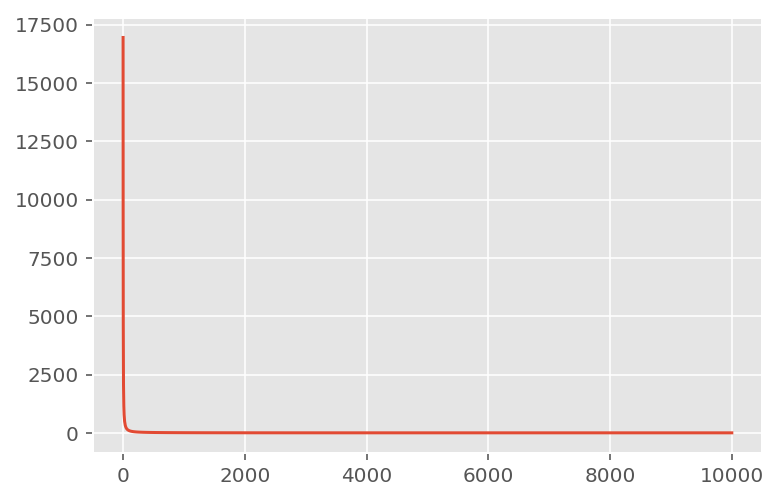

In [9]:
plt.plot(np.asarray(error));
print(r0.norm())
print(torch.dist(x, x0))
print(torch.dist(b, A.mm(x0)))

## Conjugate Gradient (CG) method

In [10]:
x0 = torch.zeros(n, 1).type(dtype)
r0 = Atb - AtA.mm(x0)
p0 = r0
# stopping criterion
Niter = 10000
tol = .01
error=[]
for k in range(Niter):
    if torch.dist(b, A.mm(x0)) < tol:
        break
    alpha = r0.norm(p=2)**2/(p0.t().mm(AtA).mm(p0))
    xk = x0 + p0*alpha.repeat(m,1)
    rk = r0 - AtA.mm(p0)*alpha.repeat(m,1)
    beta = rk.norm(p=2)**2/r0.norm(p=2)**2
    pk = rk + p0*beta
    
    p0 = pk
    x0 = xk
    r0 = rk
    error.append(r0.norm())

2.872415610206002e-14
0.8661470787481337
0.03568929970089891


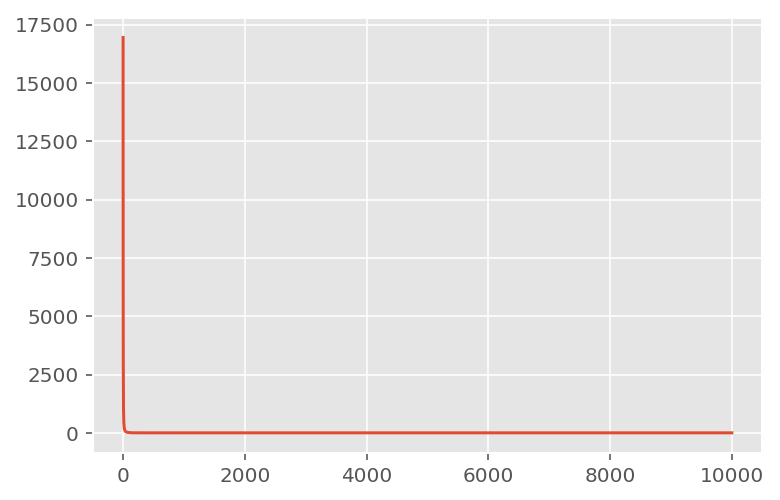

In [11]:
plt.plot(np.asarray(error));
print(r0.norm())
print(torch.dist(x, x0))
print(torch.dist(b, A.mm(x0)))

# Conjugate Gradient method for Least Squares (CGLS)

In [12]:
x0 = torch.zeros(n, 1).type(dtype)
d0 = b - A.mm(x0)
r0 = A.t().mm(d0)
p0 = r0
y0 = A.mm(p0)
# stopping criterion
Niter = 10000
tol = .01
error=[]
for k in range(Niter):
    if torch.dist(b, A.mm(x0)) < tol:
        break
    alpha = r0.norm(p=2)**2/y0.norm(p=2)**2
    xk = x0 + p0*alpha
    dk = d0 - y0*alpha
    rk = A.t().mm(dk)
    beta = rk.norm(p=2)**2/r0.norm(p=2)**2
    pk = rk + p0*beta
    yk = A.mm(pk)
    
    p0 = pk
    x0 = xk
    d0 = dk
    r0 = rk
    y0 = yk
    error.append(r0.norm())

0.0293040277508046
0.1497066537612167
0.009970857216118833


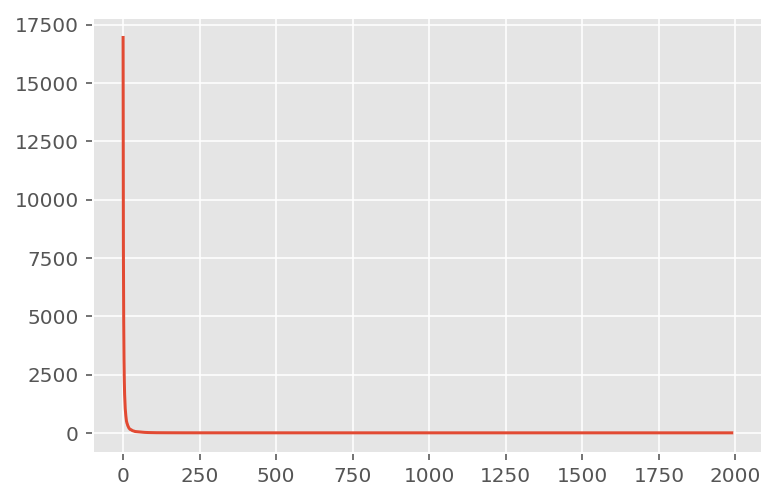

In [13]:
plt.plot(np.asarray(error));
print(r0.norm())
print(torch.dist(x, x0))
print(torch.dist(b, A.mm(x0)))

# Generalized Minimal RESidual (GMRES) method
https://en.wikipedia.org/wiki/Generalized_minimal_residual_method#Regular_GMRES_.28MATLAB_.2F_GNU_Octave.29

In [76]:
x0 = torch.zeros(n, 1).type(dtype)
r0 = b - A.mm(x0)
v1 = r0 / r0.norm()
b_norm = b.norm()
j = 0
# stopping criterion
Niter = 10000
sn = np.zeros((Niter, 1), dtype=float32)
cs = np.zeros((Niter, 1), dtype=float32)
e1 = np.zeros((Niter, 1), dtype=float32)
e1[0] = 1;

beta = r0.norm()*e1;
tol = .01
error = []
error.append(r0.norm())
for k in range(Niter):
    if error[k] < tol:
        break
    """
    Arnoldi Function
    """
    wj = A.mm(v1)
    if k==0:
        V = v1
        H = wj.t().mm(V)
    else:
        V = torch.cat((V, v1), 1)
        H = torch.cat((H, wj.t().mm(V).t()),1)
    
    wj -= torch.sum(torch.ger(V[:,-1], H[:,-1]), dim=1)
    
    j += 1
    H = torch.cat((H, torch.zeros(1, j)),0)
    H[-1,-1]=wj.norm()
    
    if wj.norm()==0:
        break
    else:
        v1 = wj/wj.norm()
        
    """
    Givens Rotation
    """
    h = H[:,-1].numpy()
    for i in range(k-1):
        temp = cs[i]*h[i] + sn[i]*h[i+1]
        h[i+1] = -sn[i]*h[i] + cs[i]*h[i+1]
        h[i]   = temp
        
    if h[k]==0:
        cs[k]=0
        sn[k]=1
    else:
        t = np.sqrt(h[k]**2+h[k+1]**2)
        cs[k] = abs(h[k]) / t
        sn[k] = cs[k] * h[k+1] / h[k]
        
    h[k] = cs[k]*h[k] + sn[k]*h[k+1]
    h[k+1] = 0.0
    H[:,-1] = torch.from_numpy(h)
    
    # update the residual vector
    beta[k+1] = -sn[k]*beta[k]
    beta[k]   = cs[k]*beta[k]
    error.append(abs(beta[k+1]) / b_norm)

# calculate the result
beta_ = torch.from_numpy(beta[:k])
y, _ = torch.gels(beta_, H[:k,:k])
x0 = V.mm(y)

40.784105503477086
1274.456011402512


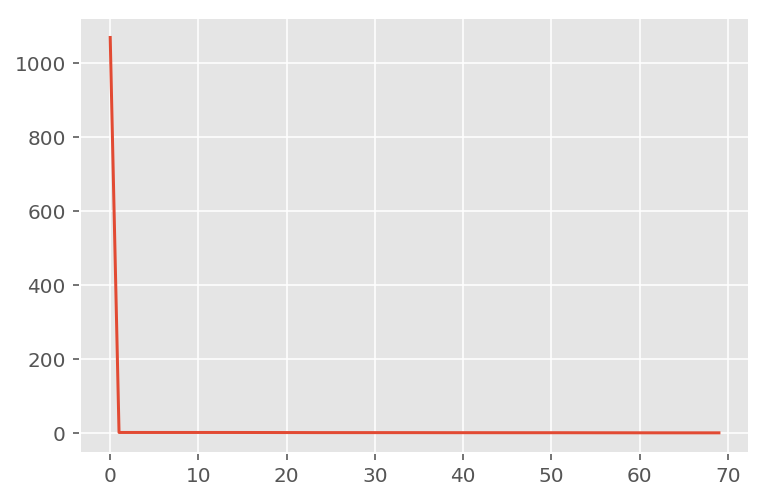

In [77]:
plt.plot(np.asarray(error));
print(torch.dist(x, x0))
print(torch.dist(b, A.mm(x0)))